<a href="https://colab.research.google.com/github/sujalgawas/anime_faces_GAN/blob/main/animes_face_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [5]:
!pip install opendatasets --upgrade --quiet

In [6]:
import opendatasets as od

dataset_url = 'https://www.kaggle.com/splcher/animefacedataset'
od.download(dataset_url)

Dataset URL: https://www.kaggle.com/datasets/splcher/animefacedataset


100%|██████████| 395M/395M [00:23<00:00, 17.3MB/s]


In [7]:
import os

DATA_DIR = './animefacedataset'
print(os.listdir(DATA_DIR))

['images']


In [8]:
print(os.listdir(DATA_DIR+'/images')[:10])

['55706_2016.jpg', '5117_2003.jpg', '44726_2013.jpg', '17559_2007.jpg', '13453_2006.jpg', '11116_2005.jpg', '25339_2009.jpg', '62349_2019.jpg', '50809_2015.jpg', '13111_2005.jpg']


In [9]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [10]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [11]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [12]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [14]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

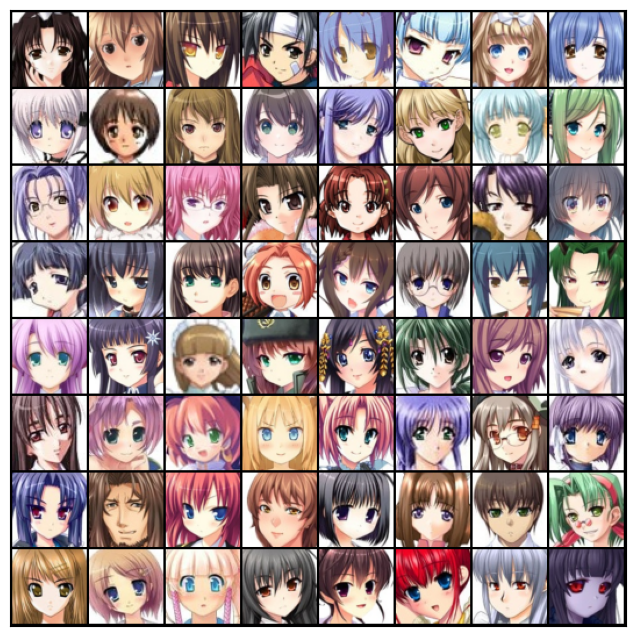

In [15]:
show_batch(train_dl)

In [16]:
device = get_default_device()
device

device(type='cuda')

In [17]:
train_dl = DeviceDataLoader(train_dl, device)

In [18]:
import torch.nn as nn

In [19]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [20]:
discriminator = to_device(discriminator, device)

In [21]:
latent_size = 128

In [22]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


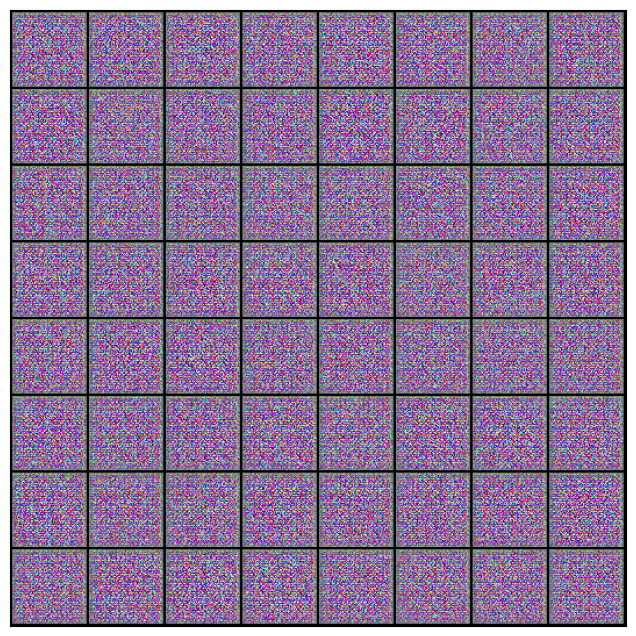

In [23]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [24]:
generator = to_device(generator, device)

In [25]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [26]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)

    # Update generator weights
    loss.backward()
    opt_g.step()

    return loss.item()

In [27]:
from torchvision.utils import save_image

In [28]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [29]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [30]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving generated-images-0000.png


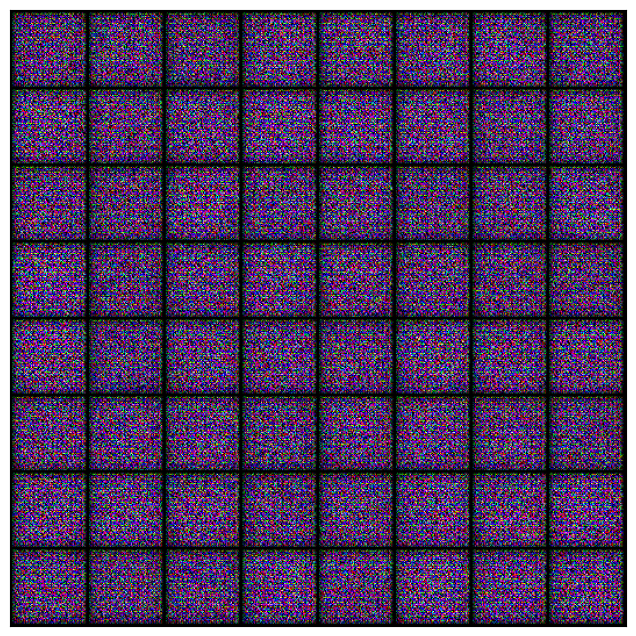

In [31]:
save_samples(0, fixed_latent)

In [32]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [33]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()

    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)

        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores

In [34]:
lr = 0.0002
epochs = 25

In [35]:
history = fit(epochs, lr)

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [1/25], loss_g: 4.9971, loss_d: 0.4912, real_score: 0.9085, fake_score: 0.2958
Saving generated-images-0001.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [2/25], loss_g: 4.5199, loss_d: 0.4055, real_score: 0.8520, fake_score: 0.1803
Saving generated-images-0002.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [3/25], loss_g: 6.1316, loss_d: 0.1247, real_score: 0.9028, fake_score: 0.0118
Saving generated-images-0003.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [4/25], loss_g: 5.2378, loss_d: 0.4484, real_score: 0.7114, fake_score: 0.0049
Saving generated-images-0004.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [5/25], loss_g: 5.0199, loss_d: 0.1229, real_score: 0.9391, fake_score: 0.0487
Saving generated-images-0005.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [6/25], loss_g: 5.9878, loss_d: 0.1217, real_score: 0.9575, fake_score: 0.0701
Saving generated-images-0006.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [7/25], loss_g: 10.7108, loss_d: 0.2945, real_score: 0.9915, fake_score: 0.2320
Saving generated-images-0007.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [8/25], loss_g: 7.0046, loss_d: 0.1887, real_score: 0.8802, fake_score: 0.0027
Saving generated-images-0008.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [9/25], loss_g: 5.9710, loss_d: 0.1067, real_score: 0.9393, fake_score: 0.0219
Saving generated-images-0009.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [10/25], loss_g: 5.0061, loss_d: 0.3045, real_score: 0.8897, fake_score: 0.0441
Saving generated-images-0010.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [11/25], loss_g: 5.7781, loss_d: 0.0655, real_score: 0.9605, fake_score: 0.0166
Saving generated-images-0011.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [12/25], loss_g: 6.3098, loss_d: 0.0845, real_score: 0.9660, fake_score: 0.0406
Saving generated-images-0012.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [13/25], loss_g: 5.4666, loss_d: 0.0252, real_score: 0.9975, fake_score: 0.0218
Saving generated-images-0013.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [14/25], loss_g: 5.1364, loss_d: 0.0540, real_score: 0.9676, fake_score: 0.0164
Saving generated-images-0014.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [15/25], loss_g: 6.7858, loss_d: 0.0969, real_score: 0.9660, fake_score: 0.0511
Saving generated-images-0015.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [16/25], loss_g: 6.0728, loss_d: 0.0593, real_score: 0.9650, fake_score: 0.0130
Saving generated-images-0016.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [17/25], loss_g: 5.5387, loss_d: 0.1503, real_score: 0.9155, fake_score: 0.0075
Saving generated-images-0017.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [18/25], loss_g: 5.9852, loss_d: 0.0902, real_score: 0.9497, fake_score: 0.0301
Saving generated-images-0018.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [19/25], loss_g: 9.5816, loss_d: 0.0300, real_score: 0.9883, fake_score: 0.0163
Saving generated-images-0019.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [20/25], loss_g: 9.6553, loss_d: 0.0789, real_score: 0.9498, fake_score: 0.0155
Saving generated-images-0020.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [21/25], loss_g: 21.5882, loss_d: 0.0526, real_score: 0.9729, fake_score: 0.0000
Saving generated-images-0021.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [22/25], loss_g: 6.7534, loss_d: 0.0200, real_score: 0.9844, fake_score: 0.0032
Saving generated-images-0022.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [23/25], loss_g: 9.7722, loss_d: 0.0336, real_score: 0.9950, fake_score: 0.0261
Saving generated-images-0023.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [24/25], loss_g: 5.7659, loss_d: 0.0718, real_score: 0.9598, fake_score: 0.0136
Saving generated-images-0024.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [25/25], loss_g: 5.6858, loss_d: 0.0592, real_score: 0.9664, fake_score: 0.0105
Saving generated-images-0025.png


In [36]:
losses_g, losses_d, real_scores, fake_scores = history

In [37]:
from IPython.display import Image

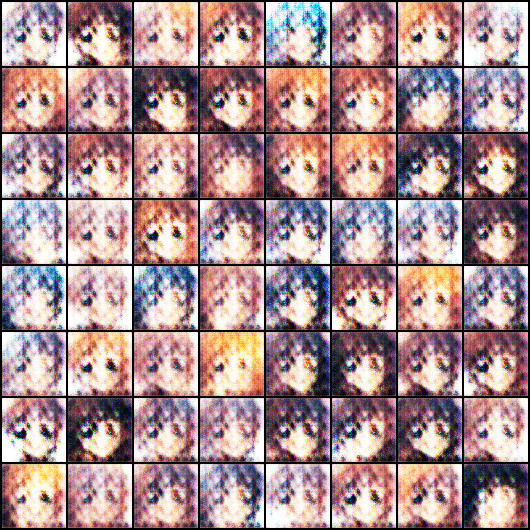

In [38]:
Image('./generated/generated-images-0001.png')

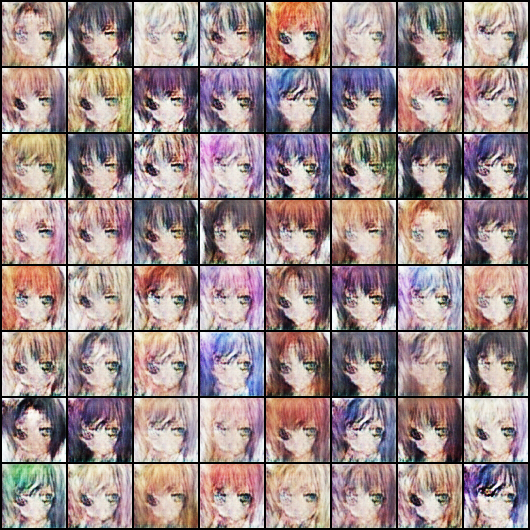

In [39]:
Image('./generated/generated-images-0005.png')

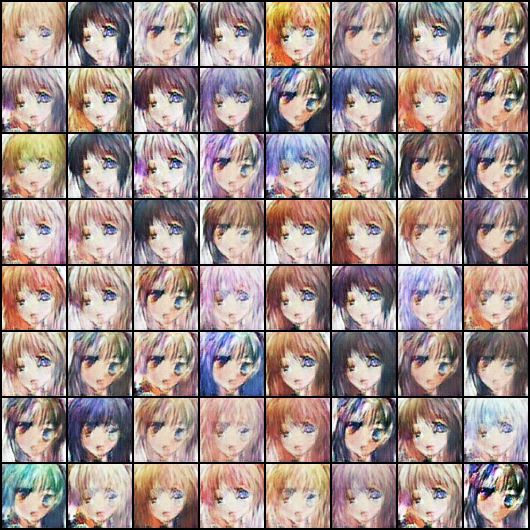

In [40]:
Image('./generated/generated-images-0010.png')

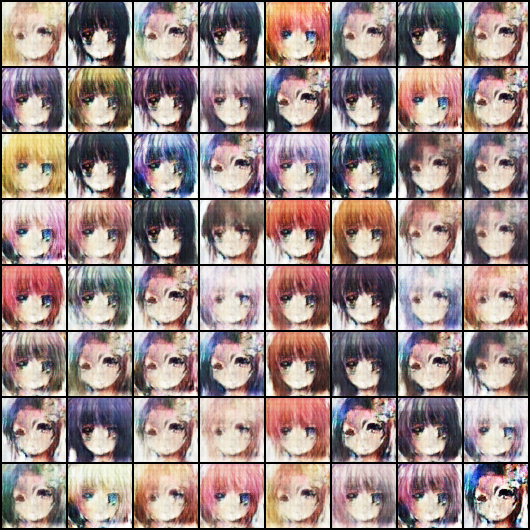

In [41]:
Image('./generated/generated-images-0020.png')

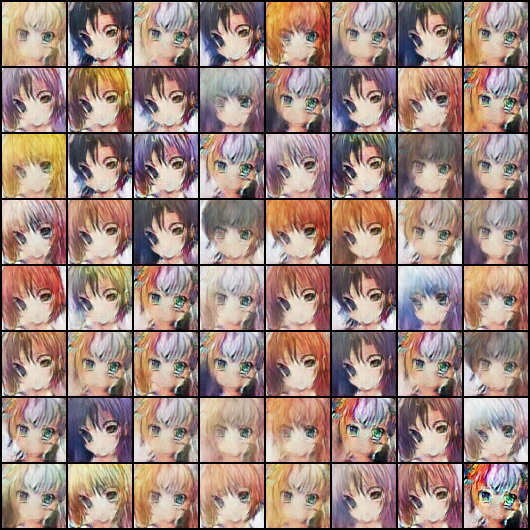

In [42]:
Image('./generated/generated-images-0025.png')

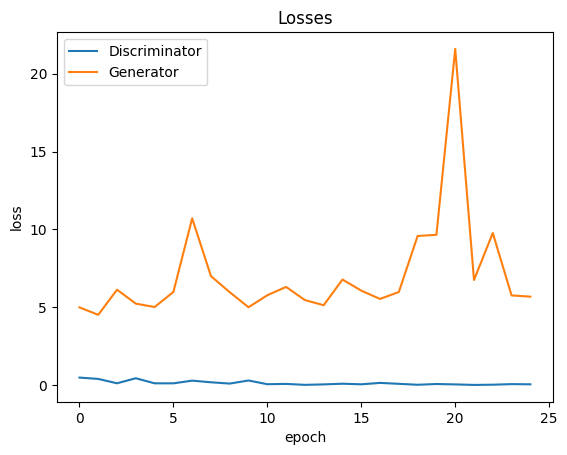

In [43]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

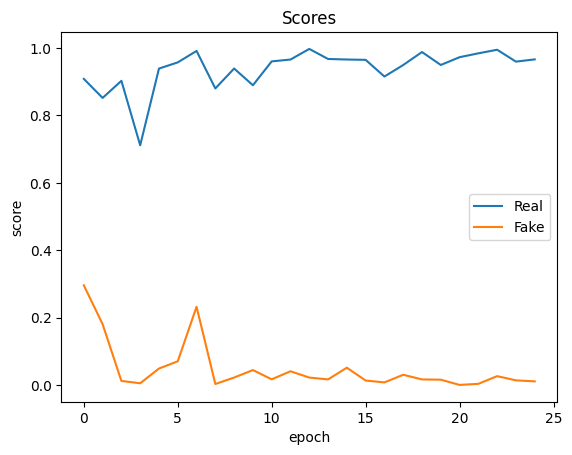

In [44]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');